<a href="https://colab.research.google.com/github/djiraffs/Deep-Learning/blob/main/Week%203/Week_3_Tugas_CNN_CIFAR_100_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

METODE PYTORCH

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

Hyper parameter

In [19]:
# Hyperparameters
batch_size = 128
epochs = 30  # Tambah jumlah epoch jadi 30
learning_rate = 0.1  # Learning rate tinggi untuk training awal
momentum = 0.9  # Momentum untuk stabilisasi update
weight_decay = 5e-4  # Regularisasi agar tidak overfitting


Data transform

In [20]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Load dataset

In [21]:
train_dataset = datasets.CIFAR100(root="./data", train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR100(root="./data", train=False, transform=transform_test, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [22]:
# Define CNN Model with more filters and dropout
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 64 filters
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),  # Tambah dropout

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256 filters
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),  # Dropout lebih tinggi

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 512 filters
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)  # Dropout tertinggi
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 100)  # Output 100 kelas
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


optimizer

In [23]:
# Optimizer & Learning Rate Scheduler
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


Training loop

In [24]:
# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    scheduler.step()  # Update learning rate setiap epoch
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_acc:.2f}%")


Epoch [1/30], Loss: 1.8216, Training Accuracy: 49.90%
Epoch [2/30], Loss: 1.7533, Training Accuracy: 51.44%
Epoch [3/30], Loss: 1.7834, Training Accuracy: 50.65%
Epoch [4/30], Loss: 1.8291, Training Accuracy: 49.52%
Epoch [5/30], Loss: 1.8616, Training Accuracy: 49.03%
Epoch [6/30], Loss: 1.8932, Training Accuracy: 48.27%
Epoch [7/30], Loss: 1.9245, Training Accuracy: 47.48%
Epoch [8/30], Loss: 1.9299, Training Accuracy: 47.49%
Epoch [9/30], Loss: 1.9362, Training Accuracy: 47.48%
Epoch [10/30], Loss: 1.9207, Training Accuracy: 47.82%
Epoch [11/30], Loss: 1.9052, Training Accuracy: 47.95%
Epoch [12/30], Loss: 1.8962, Training Accuracy: 48.44%
Epoch [13/30], Loss: 1.8675, Training Accuracy: 49.07%
Epoch [14/30], Loss: 1.8379, Training Accuracy: 49.69%
Epoch [15/30], Loss: 1.7990, Training Accuracy: 50.56%
Epoch [16/30], Loss: 1.7520, Training Accuracy: 51.73%
Epoch [17/30], Loss: 1.7134, Training Accuracy: 52.83%
Epoch [18/30], Loss: 1.6654, Training Accuracy: 53.90%
Epoch [19/30], Loss

Evaluasi

In [25]:
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_scores, multi_class='ovr')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Test Accuracy: 67.03%
Precision: 0.6701
Recall: 0.6703
F1 Score: 0.6674
AUC: 0.9896


**METODE TENSORFLOW**

Import library dan dataset

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Load Dataset CIFAR-100
(ds_train, ds_test), ds_info = tfds.load(
    "cifar100",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (32, 32))  # Pastikan ukuran sesuai
    image = (image - 0.5) / 0.5  # Normalize ke [-1,1]
    return image, label

# Apply preprocessing & batching
batch_size = 128
ds_train = ds_train.map(preprocess).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/incomplete.A2XY3U_3.0.2/cifar100-train.tfrecord*...:   0%|       …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/incomplete.A2XY3U_3.0.2/cifar100-test.tfrecord*...:   0%|        …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


Model CNN Tensorflow

In [27]:
# Define CNN Model
def create_cnn():
    model = keras.Sequential([
        layers.Conv2D(64, (3,3), padding="same", activation="relu", input_shape=(32,32,3)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.4),

        layers.Conv2D(512, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(1024, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(100, activation="softmax")  # 100 kelas output
    ])
    return model

# Inisialisasi model
model = create_cnn()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile model

In [28]:
# Optimizer & Learning Rate Scheduler
initial_lr = 0.1
lr_schedule = keras.optimizers.schedules.CosineDecay(initial_lr, decay_steps=30 * len(ds_train))

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, decay=5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Training Model

In [29]:
# Training model
epochs = 30  # Tambah epoch agar model lebih optimal

history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=epochs
)


Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 65s 116ms/step - accuracy: 0.0093 - loss: 7.1911 - val_accuracy: 0.0100 - val_loss: 4.6060
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - accuracy: 0.0091 - loss: 4.6078 - val_accuracy: 0.0100 - val_loss: 4.6060
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.0091 - loss: 4.6077 - val_accuracy: 0.0100 - val_loss: 4.6062
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.0091 - loss: 4.6081 - val_accuracy: 0.0100 - val_loss: 4.6060
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.0085 - loss: 4.6079 - val_accuracy: 0.0100 - val_loss: 4.6060
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.0093 - loss: 4.6077 - val_accuracy: 0.0100 - val_loss: 4.6059
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.0101 - loss: 4.6074 - val_accuracy: 0.0100 - val_loss: 4.6059
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.0083 - loss: 4.6074 -

Evaluate

In [30]:
# Evaluasi Model
test_loss, test_acc = model.evaluate(ds_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0123 - loss: 4.6052

Test Accuracy: 1.00%


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Prediksi pada test set
y_true = []
y_pred = []
y_scores = []

for images, labels in ds_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())  # Label asli
    y_pred.extend(np.argmax(preds, axis=1))  # Prediksi kelas
    y_scores.extend(preds)  # Probabilitas output softmax

# Menghitung Metode Evaluasi
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_scores, multi_class='ovr')

# Menampilkan Hasil Evaluasi
print("\n==== EVALUASI MODEL ====")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



==== EVALUASI MODEL ====
Test Accuracy: 1.00%
Precision: 0.0001
Recall: 0.0100
F1 Score: 0.0002
AUC: 0.5000


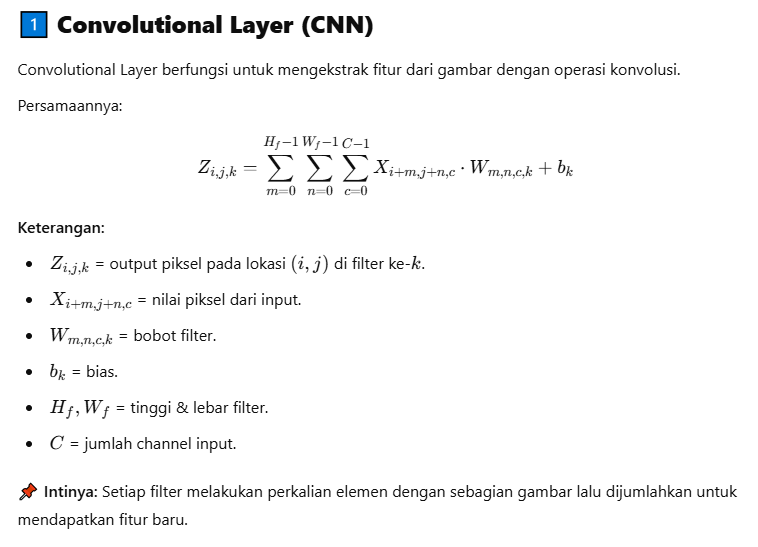

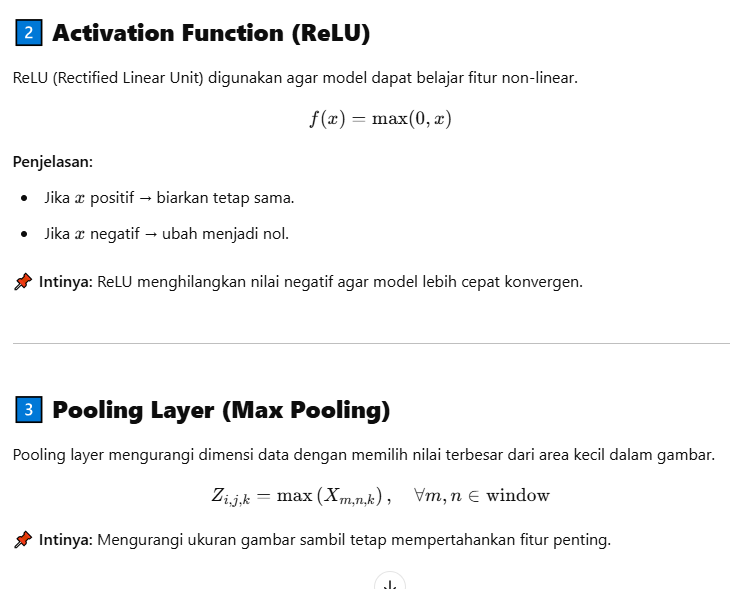

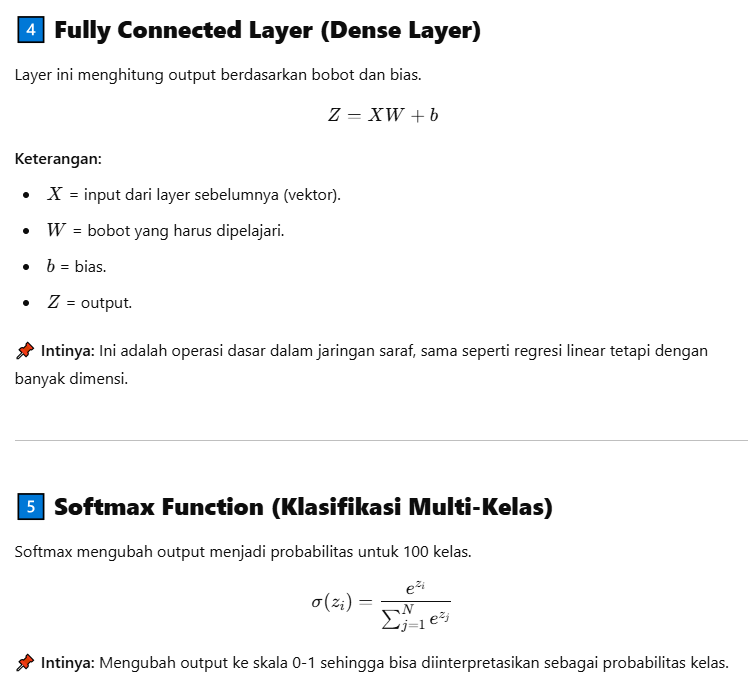

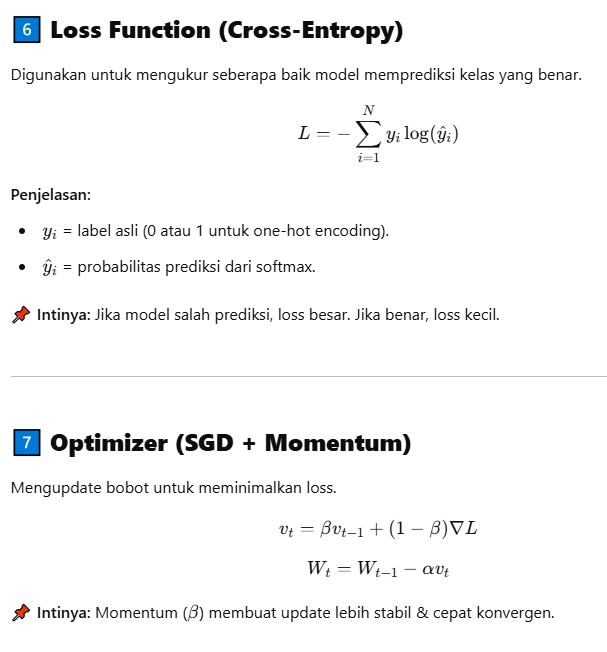

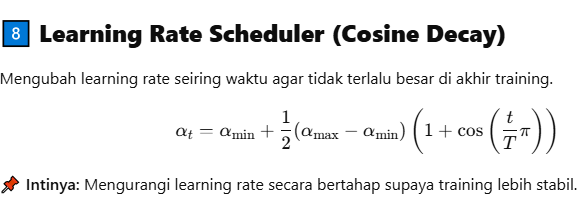

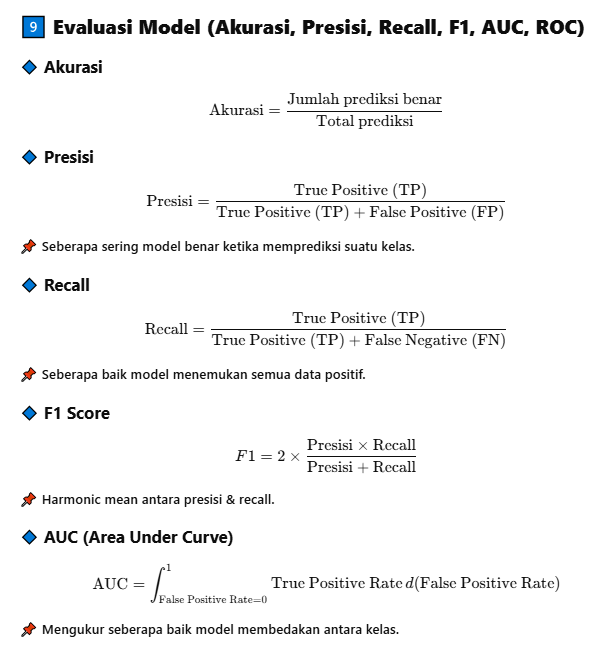